# Inspect masks and predictions
## Masks
### Generated Masks from raw Data
Show a random mask generated with the [script](../own_scripts/generate_masks_from_JSON.py) using the JSON with the corresponding annotations.

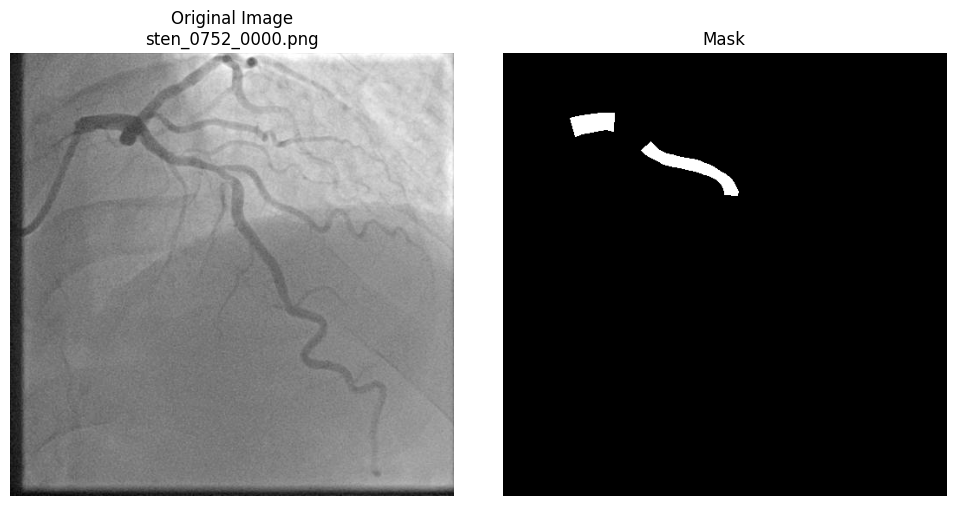

In [173]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Define paths
data_root = "../nnNet_training/Raw_data/Dataset_train_val"
image_dir = os.path.join(data_root, "imagesTr")
mask_dir = os.path.join(data_root, "labelsTr")

def load_random_image_and_mask():
    """Loads a random image and its corresponding mask."""
    image_files = [f for f in os.listdir(image_dir) if f.endswith(".png")]
    if not image_files:
        print("No images found.")
        return None, None, None
    
    random_image = random.choice(image_files)
    image_path = os.path.join(image_dir, random_image)
    mask_filename = random_image.replace("_0000.png", ".png")  # Ensure correct mapping
    mask_path = os.path.join(mask_dir, mask_filename)
    
    if not os.path.exists(mask_path):
        print(f"Mask not found for {random_image}")
        return None, None, None
    
    return Image.open(image_path), Image.open(mask_path), random_image

def visualize_image_and_mask():
    """Plots a random image and its corresponding mask."""
    image, mask, filename = load_random_image_and_mask()
    
    if image is None or mask is None:
        print("Could not load image and mask.")
        return
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(image, cmap="gray" if image.mode == "L" else None)
    axes[0].set_title(f"Original Image\n{filename}")
    axes[0].axis("off")
    
    axes[1].imshow(mask, cmap="gray")
    axes[1].set_title("Mask")
    axes[1].axis("off")
    
    plt.tight_layout()
    plt.show()

# Run visualization
visualize_image_and_mask()

### Selected Images with no masks
During the mask generation some masks seem to have no annotations. We try to look at them and ensure, it's not an error in the implementation.

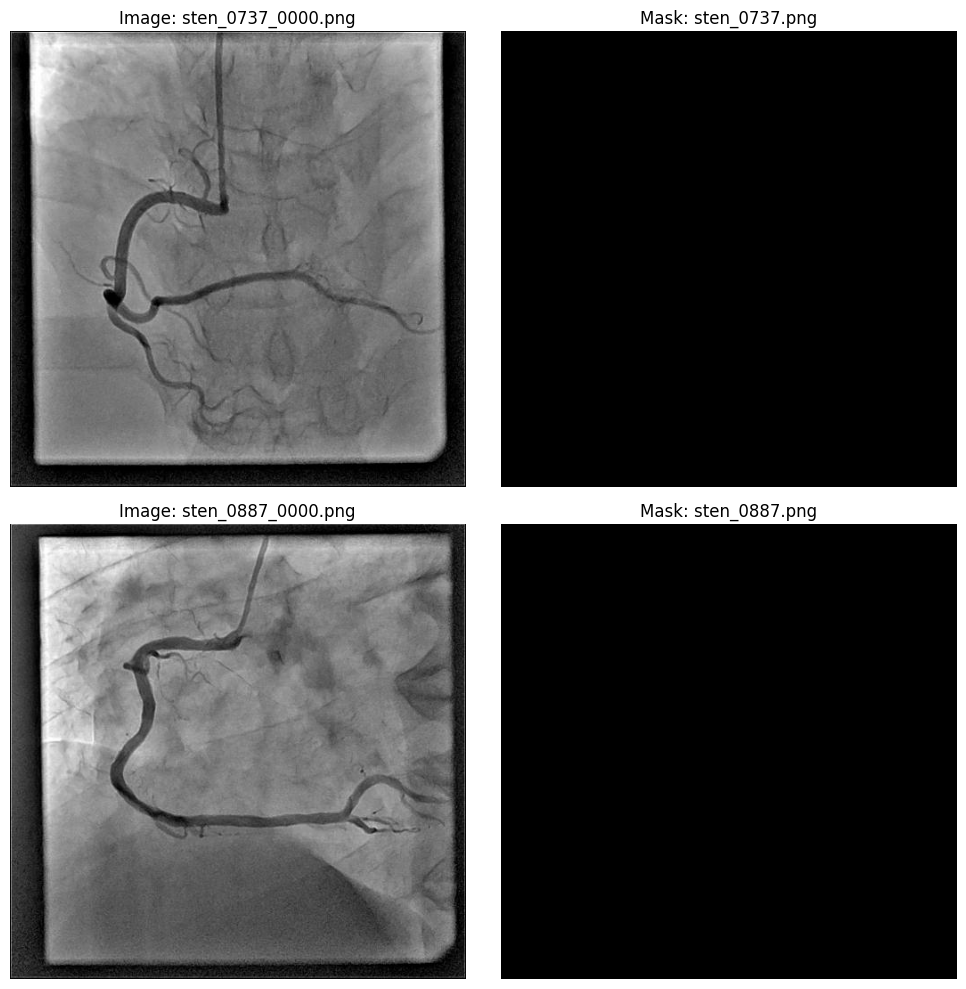

In [174]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Paths for images and masks
image_paths = [
    "../nnNet_training/Raw_data/Dataset_Train_val/imagesTr/sten_0737_0000.png",
    "../nnNet_training/Raw_data/Dataset_Train_val/imagesTr/sten_0887_0000.png"
]

mask_paths = [
    "../nnNet_training/Raw_data/Dataset_Train_val/labelsTr/sten_0737.png",
    "../nnNet_training/Raw_data/Dataset_Train_val/labelsTr/sten_0887.png"
    ]

def load_image(image_path):
    """Load an image if it exists, otherwise return None."""
    if os.path.exists(image_path):
        return Image.open(image_path)
    return None

# Plot images and masks
num_images = len(image_paths)
fig, axes = plt.subplots(num_images, 2, figsize=(10, 5 * num_images))

for i, (img_path, mask_path) in enumerate(zip(image_paths, mask_paths)):
    img = load_image(img_path)
    mask = load_image(mask_path)

    # Plot Image
    axes[i, 0].axis("off")
    if img:
        axes[i, 0].imshow(img, cmap="gray" if img.mode == "L" else None)
        axes[i, 0].set_title(f"Image: {os.path.basename(img_path)}")
    else:
        axes[i, 0].text(0.5, 0.5, "Image Not Found", color="red", fontsize=12, ha="center")
        axes[i, 0].set_title(f"Missing Image: {os.path.basename(img_path)}")

    # Plot Mask
    axes[i, 1].axis("off")
    if mask:
        axes[i, 1].imshow(mask, cmap="gray")
        axes[i, 1].set_title(f"Mask: {os.path.basename(mask_path)}")
    else:
        axes[i, 1].text(0.5, 0.5, "Mask Not Found", color="red", fontsize=12, ha="center")
        axes[i, 1].set_title(f"Missing Mask: {os.path.basename(mask_path)}")

plt.tight_layout()
plt.show()

### Comaparison GT Segmentation and manually generated Masks
In the README.md there is a hint that the folder structure should look the way it's described. There is also a labelsTr folder, therefore we have a script, which manually generates the script. But during the training process, the generation of the masks is also part. Therefore i want to look at bot of them if they look the same way.

In [162]:
path_gt = "../nnNet_training/nnUNet_preprocessed/Dataset_Train_val/gt_segmentations/"
path_lables = "../nnNet_training/Raw_data/Dataset_Train_val/labelsTr/"

# Load mask
mask = Image.open(os.path.join(path_gt, "sten_0005.png"))
mask1 = Image.open(os.path.join(path_lables, "sten_0005.png"))

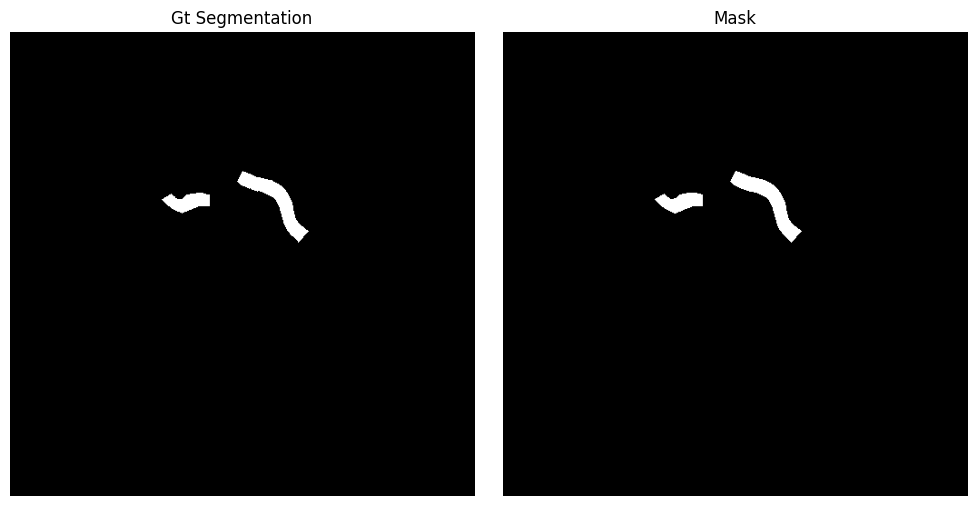

In [163]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(mask, cmap="gray" if mask.mode == "L" else None)
axes[0].set_title(f"Gt Segmentation")
axes[0].axis("off")

axes[1].imshow(mask1, cmap="gray")
axes[1].set_title("Mask")
axes[1].axis("off")

plt.tight_layout()
plt.show()

## Predictions
During training we used fold x (can be changed) for the validation. In the summary.json file in the validation folder there is the prediction with its scores for each case. We want to look at them and ensure its correctness.

### Validation set

(-0.5, 511.5, 511.5, -0.5)

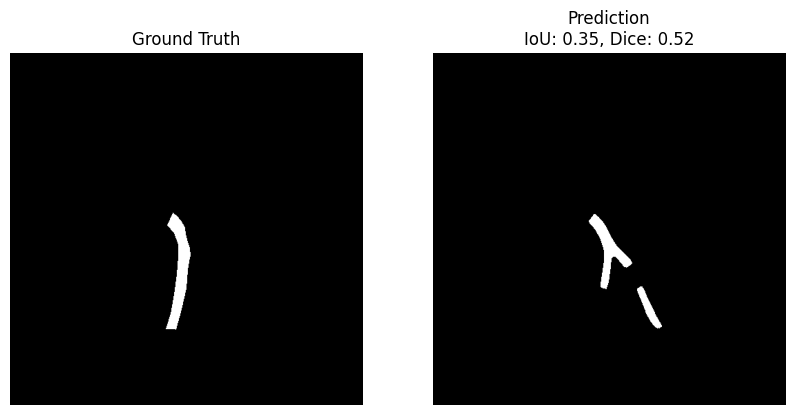

In [266]:
# Just show one selected image

path_pred = "../nnNet_training/nnUNet_results/Dataset_Train_val/nnUNetTrainer__nnUNetPlans__2d/fold_0/validation/sten_0109.png"
path_gt = "../nnNet_training/nnUNet_preprocessed/Dataset_Train_val/gt_segmentations/sten_0109.png"

# Function to compute IoU and Dice Score
def compute_iou_dice(gt_mask, pred_mask):
    """Compute IoU and Dice Score between GT and predictions."""
    intersection = np.logical_and(gt_mask, pred_mask).sum()
    union = np.logical_or(gt_mask, pred_mask).sum()
    iou = intersection / union if union != 0 else 0.0
    dice = (2 * intersection) / (gt_mask.sum() + pred_mask.sum()) if (gt_mask.sum() + pred_mask.sum()) != 0 else 0.0
    return iou, dice

score = compute_iou_dice(np.array(Image.open(path_gt)), np.array(Image.open(path_pred)))

# Plot the images and the score on the prediction
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(Image.open(path_gt), cmap="gray")
axes[0].set_title("Ground Truth")
axes[0].axis("off")

axes[1].imshow(Image.open(path_pred), cmap="gray")
axes[1].set_title(f"Prediction\nIoU: {score[0]:.2f}, Dice: {score[1]:.2f}")
axes[1].axis("off")

Thsi is exactly the dice and IoU score which is in the summary.json file.

### Test
We also have the predictions for the test set, but not the scores. Therefore we want to inspect them and look at the scores.

In [269]:
path_test = "../dataset_test_pretrained_own_test"
path_raw_data = "raw"
path_labels = "labels"
path_preprocessed_data = "preprocessed"
path_raw_prediction = "raw_prediction"
path_post_prediction = "post_prediction"

path_mask = "sten_0009.png"
path_mask_1 = "sten_0009_0000.png"

full_raw_path = os.path.join(path_test, path_raw_data, path_mask_1)
full_preprocessed_path = os.path.join(path_test, path_preprocessed_data, path_mask_1)
full_raw_prediction_path = os.path.join(path_test, path_raw_prediction, path_mask)
full_post_prediction_path = os.path.join(path_test, path_post_prediction, path_mask)
full_mask_path = os.path.join(path_test, path_labels, path_mask)


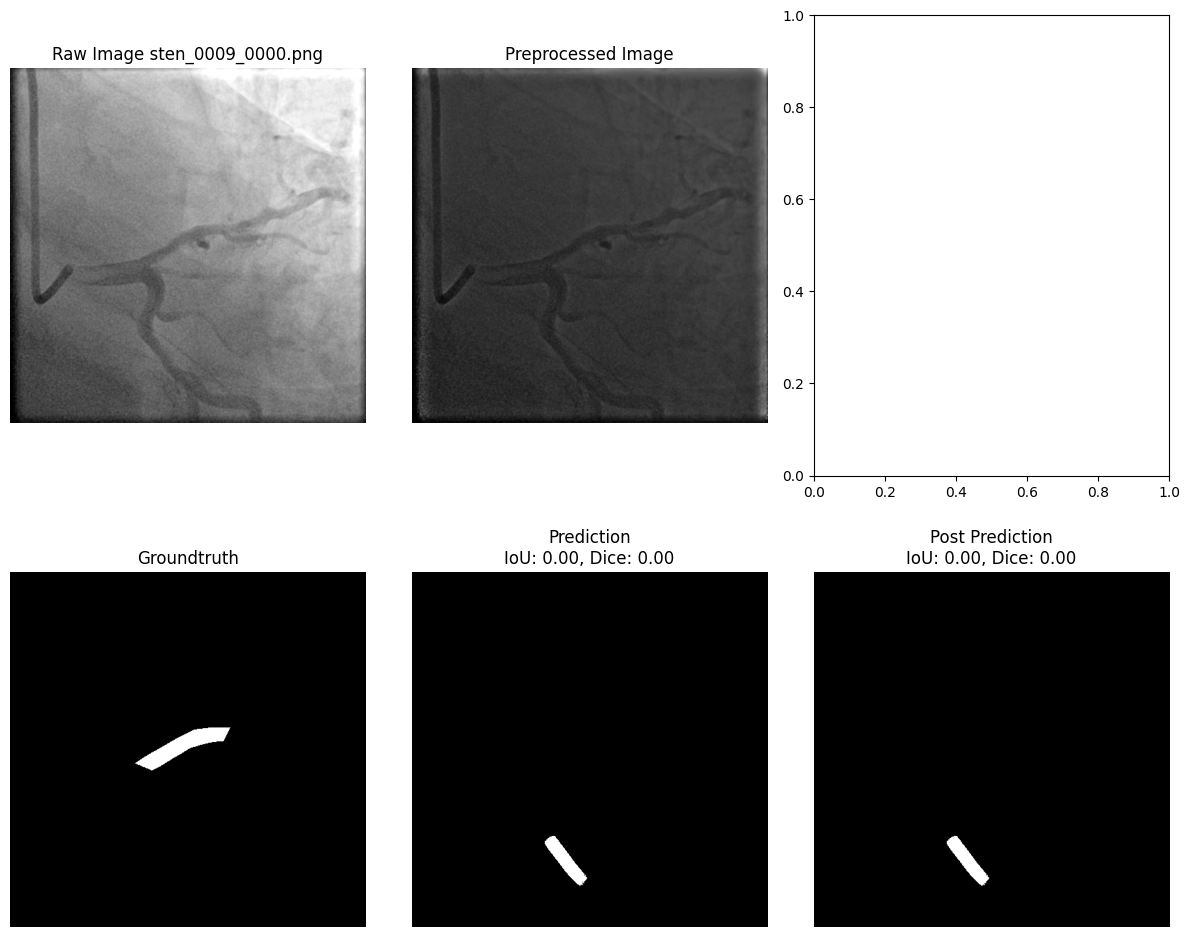

In [271]:
# Load images
raw_image = Image.open(full_raw_path)
raw_mask = Image.open(full_mask_path)
preprocessed_image = Image.open(full_preprocessed_path)
raw_prediction_mask = Image.open(full_raw_prediction_path)
post_prediction_mask = Image.open(full_post_prediction_path)

# Ensure grayscale mode
raw_mask = np.array(Image.open(full_mask_path).convert("L"))
raw_prediction_mask = np.array(Image.open(full_raw_prediction_path).convert("L"))
post_prediction_mask = np.array(Image.open(full_post_prediction_path).convert("L"))

# Ensure binary format (0 and 1)
raw_mask = (raw_mask > 0).astype(np.uint8)
raw_prediction_mask = (raw_prediction_mask > 0).astype(np.uint8)
post_prediction_mask = (post_prediction_mask > 0).astype(np.uint8)

score_raw = compute_iou_dice(raw_mask, np.array(Image.open(full_raw_prediction_path)))
score_post = compute_iou_dice(raw_mask, np.array(Image.open(full_post_prediction_path)))

# Create 2x2 subplot
fig, axes = plt.subplots(2, 3, figsize=(12, 10))

# Plot Raw Image
axes[0, 0].imshow(raw_image, cmap="gray")
axes[0, 0].set_title(f"Raw Image {path_mask_1}")
axes[0, 0].axis("off")

# Plot Preprocessed Image
axes[0, 1].imshow(preprocessed_image, cmap="gray")
axes[0, 1].set_title("Preprocessed Image")
axes[0, 1].axis("off")

# Plotq Mask
axes[1, 0].imshow(raw_mask, cmap="gray")
axes[1, 0].set_title("Groundtruth")
axes[1, 0].axis("off")

# Plot Raw Prediction Mask
axes[1, 1].imshow(raw_prediction_mask, cmap="gray")
axes[1, 1].set_title(f"Prediction\nIoU: {score_raw[0]:.2f}, Dice: {score_raw[1]:.2f}")
axes[1, 1].axis("off")

# Plot Post Prediction Mask
axes[1, 2].imshow(post_prediction_mask, cmap="gray")
axes[1, 2].set_title(f"Post Prediction\nIoU: {score_post[0]:.2f}, Dice: {score_post[1]:.2f}")
axes[1, 2].axis("off")

# Adjust layout
plt.tight_layout()
plt.show()